# Computational and Statistical Learning Project

This university project analyzes the **CIFAR10** dataset and also applies on it some machine learning methodologies based on samples classification.

## Objectives

- Dataset analysis and description (**CIFAR10**).
- **Preprocessing** and **dimensionality reduction** (**PCA** and **LDA**) stages on the dataset.
- Preprocessed data and original data **comparison** in order to verify if the choices made are correct. This is achieved with three machine learning methods:
    - Logistic Regression
    - Ensemble method (Random Forest)
    - Convolutional Neural Network

These are three models with different *philosophies* and mechanisms, it should be useful to analyze their behaviour with the available datasets.

# Setup


In [ ]:
!pip install keras-tuner --upgrade --quiet

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.exceptions import FitFailedWarning

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

from random import randrange

import matplotlib.pyplot as plt
import seaborn as sns

# Downloading the complete dataset from Keras

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


# Data analysis

The first thing to note is that the datasets are composed of images distributed randomly, so it is not *strictly* necessary to change again the elements' position in the datasets.

## Training and test sets sizes

Below you can see the size of our datasets. In particular there are **50** thousand samples in the training set and **10** thousand samples in the test set. The sample's shape is like an **RGB image** (with 3 channels) of 32x32 pixels.

In [ ]:
print('Training datasets shape:')
print(f'- training set samples: {x_train.shape}')
print(f'- training set labels: {y_train.shape}')
print()
print('Test datasets shape:')
print(f'- test set samples: {x_test.shape}')
print(f'- test set labels: {y_test.shape}')

Training datasets shape:
- training set samples: (50000, 32, 32, 3)
- training set labels: (50000, 1)

Test datasets shape:
- test set samples: (10000, 32, 32, 3)
- test set labels: (10000, 1)


## Dataset's classes distribution

The classes in the dataset are listed in this dictionary:

In [ ]:
classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

### Training set

The histogram describing the distribution of the classes is shown below.

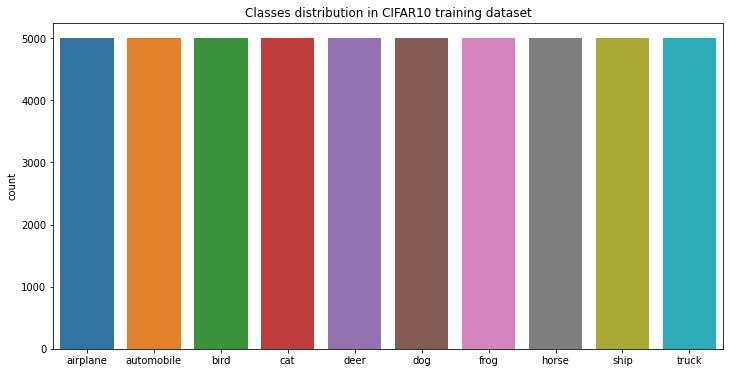

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=pd.Series(y_train.reshape(len(y_train))).map(classes), 
    order=classes.values(),
).set_title('Classes distribution in CIFAR10 training dataset')
plt.show()

#### Note

The dataset is **balanced** and each class is made by **five** thousand samples.

### Test set

The resulting class chart is as follows:

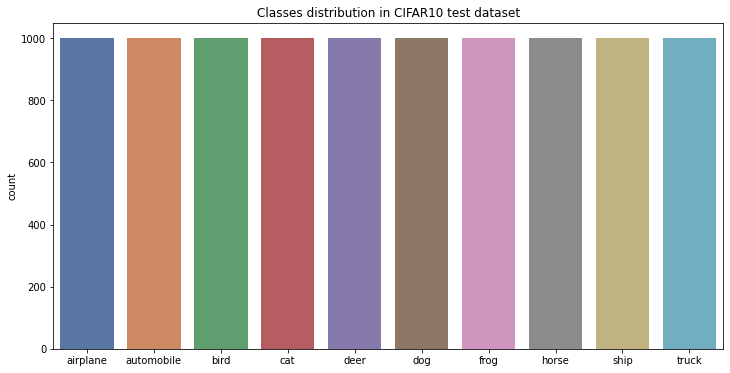

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=pd.Series(y_test.reshape(len(y_test))).map(classes),
    order=classes.values(),
    palette='deep'
).set_title('Classes distribution in CIFAR10 test dataset')
plt.show()

#### Note

Also this dataset is **balanced** and each class is made by **one** thousand samples.

## Dataset's images example

The first images of the training and test sets are showed below.

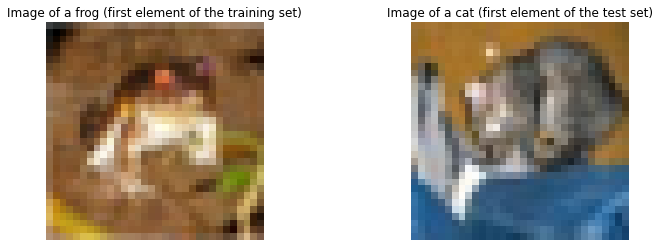

In [ ]:
fig = plt.figure(figsize = (12, 4))

ax = fig.add_subplot(121)
plt.title(f"Image of a {classes.get(y_train[0][0])} "
          "(first element of the training set)")
_ = plt.imshow(x_train[0])
ax.set_axis_off()

ax = fig.add_subplot(122)
plt.title(f"Image of a {classes.get(y_test[0][0])} "
          "(first element of the test set)")
_ = plt.imshow(x_test[0])
ax.set_axis_off()

# Preprocessing over the datasets' samples

Different preprocessing operations were made on the datasets in order to apply the **dimensionality reduction** and **learning** methods on them later.

## Dataset reduction

For better results, in terms of classification and performance, the datasets are **reduced** by **five** classes.

In [ ]:
def update_class(dataset, classes_dim):
    """This function basically updates the classes of the reduced dataset to be 
    numerated starting by 0 to (n_classes_dim - 1)
    """
    for idx, key in enumerate(classes_dim.keys()):
        dataset[dataset == key] = idx
    return dataset


classes_dim = {
    0: 'airplane',
    2: 'bird',
    4: 'deer',
    6: 'frog',
    9: 'truck'
}

mask_train = np.isin(y_train.reshape(len(y_train)), list(classes_dim.keys()))
mask_test = np.isin(y_test.reshape(len(y_test)), list(classes_dim.keys()))

x_train = x_train[mask_train]
y_train = y_train[mask_train]
y_train = update_class(y_train, classes_dim)

x_test = x_test[mask_test]
y_test = y_test[mask_test]
y_test = update_class(y_test, classes_dim)

classes_dim = {
    idx: value 
    for idx, value 
    in enumerate(classes_dim.values())
}

print(f"New training set dimension: {len(y_train)}")
print(f"New test set dimension: {len(y_test)}")

New training set dimension: 25000
New test set dimension: 5000


## RGB to grayscale conversion

Assuming that a simpler data structure of the images could bring **better** classification and dimensionality reduction results, because of less features to describe. The images will be reduced to a single channel (grayscale).

In this way, a comparison between the two models, `RGB` and `grey` , can be done. If the results will be similar, the grayscale models should be kept.

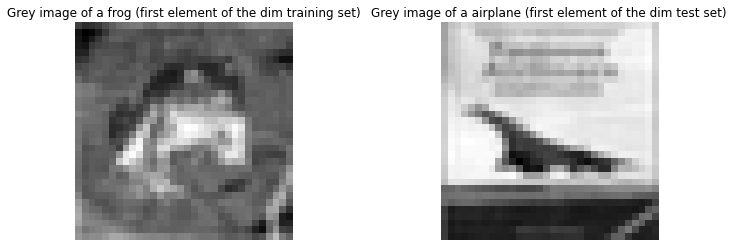

In [ ]:
# Efficient method to get the grayscalevalues.
# axis=-1 is the last element of each array i.e. the channels
x_train_grey = x_train.mean(axis=-1).astype('uint8')
x_test_grey = x_test.mean(axis=-1).astype('uint8')

fig = plt.figure(figsize = (12, 4))

ax = fig.add_subplot(121)
plt.title(f"Grey image of a {classes_dim.get(y_train[0][0])} "
          "(first element of the dim training set)")
_ = plt.imshow(x_train_grey[0], cmap='gray')
ax.set_axis_off()

ax = fig.add_subplot(122)
plt.title(f"Grey image of a {classes_dim.get(y_test[0][0])} "
          "(first element of the dim test set)")
_ = plt.imshow(x_test_grey[0], cmap='gray')
ax.set_axis_off()

## Images reshaping

Each `32x32x3` image will be *flattened* in order to apply linear methods on them. The result will be **vectors** made of `3072` components.

The same will be done on the **grayscale** images, **vectors** of `1024` components will be generated.

In [ ]:
x_train_flat = np.array([x_train[i].flatten() for i in range(len(x_train))])
x_test_flat = np.array([x_test[i].flatten() for i in range(len(x_test))])

x_train_grey_flat = np.array([x_train_grey[i].flatten() for i in range(len(x_train))])
x_test_grey_flat = np.array([x_test_grey[i].flatten() for i in range(len(x_test))])

## Dataset normalization

The training and test datasets will be normalized between [0, 1] values.

**Mean centering** and a **division of the standard deviation** returned worse results in image quality.

In [ ]:
COSTANT = 255

x_train_flat_norm = x_train_flat.astype("float32") / COSTANT
x_test_flat_norm = x_test_flat.astype("float32") / COSTANT

x_train_grey_flat_norm = x_train_grey_flat.astype("float32") / COSTANT
x_test_grey_flat_norm = x_test_grey_flat.astype("float32") / COSTANT

# Dimensionality reduction with PCA

Two **PCA** models for the two datasets will be created, then the explained variation of the four principal components will be analyzed. The four **PCs** are the components that better describe the properties of the samples.

In [ ]:
pca = PCA()
pca_grey = PCA()

pca.fit(x_train_flat_norm)
pca_grey.fit(x_train_grey_flat_norm)

print(f"RGB PCA: {pca.explained_variance_ratio_[:4]}")
print(f"Grey PCA: {pca_grey.explained_variance_ratio_[:4]}")

RGB PCA: [0.33031026 0.1115537  0.05543978 0.04504415]
Grey PCA: [0.36326915 0.12385969 0.06031491 0.03466189]


### Remark

Since the samples are images rich of features, the obtained values are not so good. An improvement can be noted compared to the PCA applied at the **entire dataset** (with ten classes), wich had an explained variation equal to `[0.26920197, 0.11370504]` for the first two components.  

The **grayscale** dataset has better results for the first three components of the PCA analisys.

### Datasets' chart about explained variation

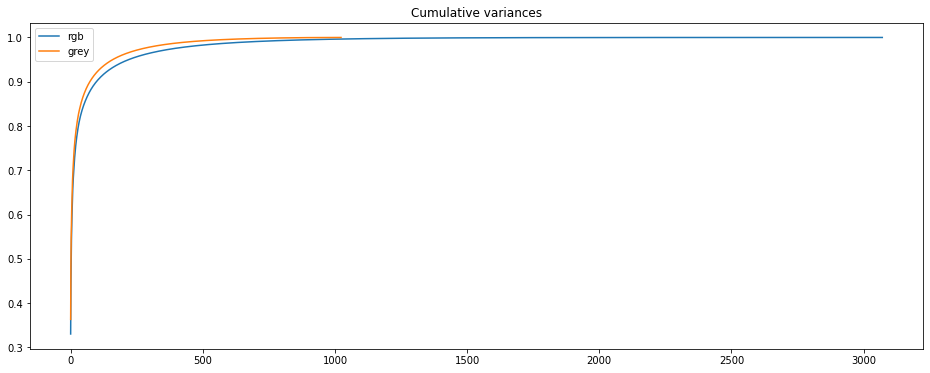

In [ ]:
# these array contain the cumulative sum of each component variance
cum_variance = np.cumsum(pca.explained_variance_ratio_)
cum_variance_grey = np.cumsum(pca_grey.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data=cum_variance, label="rgb")
sns.lineplot(data=cum_variance_grey, label="grey")
ax.set_title("Cumulative variances")
plt.legend()
plt.show()

In order to get quite **accurate** models, but also not too **resource heavy**, the number of principal components that will be taken will be the one that achieves the **95%** of explained variation.

This will be obtained by counting all the occurences in the array which has a value less than or equal to 0.95 (95%).

In [ ]:
pc_var_95 = sum(cum_variance <= 0.95)
print(f"RGB: To achieve 95% of explained variance, {pc_var_95} components are needed.")

pc_var_95_grey = sum(cum_variance_grey <= 0.95)
print(f"\nGrey: To achieve 95% of explained variance, {pc_var_95_grey} components are needed.")

RGB: To achieve 95% of explained variance, 220 components are needed.

Grey: To achieve 95% of explained variance, 160 components are needed.


### Remark

It is possible to notice that the grayscale dataset requires less components than the original dataset, so the first hypothesis were, at least, a bit reasonable.

In [ ]:
pca95 = PCA(n_components=pc_var_95)
pca95_grey = PCA(n_components=pc_var_95_grey)

x_train_pca = pca95.fit(x_train_flat_norm).transform(x_train_flat_norm)
x_train_grey_pca = pca95_grey.fit(x_train_grey_flat_norm).transform(x_train_grey_flat_norm)

x_test_pca = pca95.transform(x_test_flat_norm)
x_test_grey_pca = pca95_grey.transform(x_test_grey_flat_norm)

Below it is possible to see the **charts** of the obtained results.

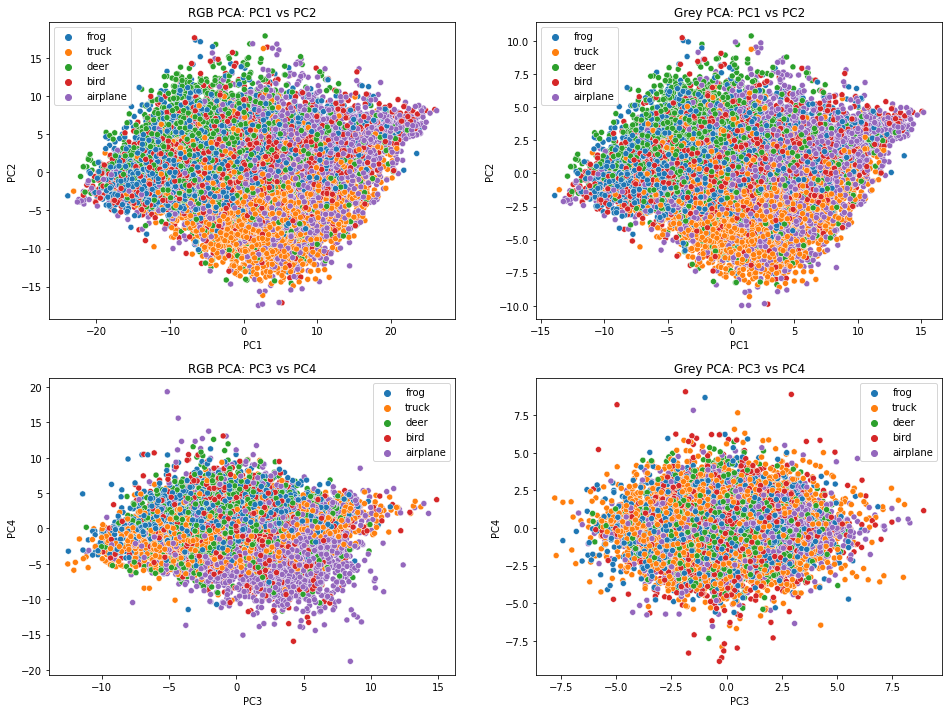

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# RGB 
sns.scatterplot(
    x=x_train_pca[:, 0], 
    y=x_train_pca[:, 1], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[0, 0],
).set_title("RGB PCA: PC1 vs PC2")
ax[0, 0].set_xlabel("PC1")
ax[0, 0].set_ylabel("PC2")

sns.scatterplot(
    x=x_train_pca[:, 2], 
    y=x_train_pca[:, 3], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[1, 0],
).set_title("RGB PCA: PC3 vs PC4")
ax[1, 0].set_xlabel("PC3")
ax[1, 0].set_ylabel("PC4")

# Grey
sns.scatterplot(
    x=x_train_grey_pca[:, 0], 
    y=x_train_grey_pca[:, 1], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[0, 1],
).set_title("Grey PCA: PC1 vs PC2")
ax[0, 1].set_xlabel("PC1")
ax[0, 1].set_ylabel("PC2")

sns.scatterplot(
    x=x_train_grey_pca[:, 2], 
    y=x_train_grey_pca[:, 3], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[1, 1],
).set_title("Grey PCA: PC3 vs PC4")
ax[1, 1].set_xlabel("PC3")
ax[1, 1].set_ylabel("PC4")

plt.show()

### Remark

The first two principal components seems quite similar for both the two **PCA** models. The components three and four are better represented by the RGB model.

It is still hard to get conclusion from these charts, this because the images has a lot of features. The performance of the datasets will be tested by the Machine Learning models later.

## Comparison between original and compressed images

This can be helpful to see how the **PCA** methodologies work.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


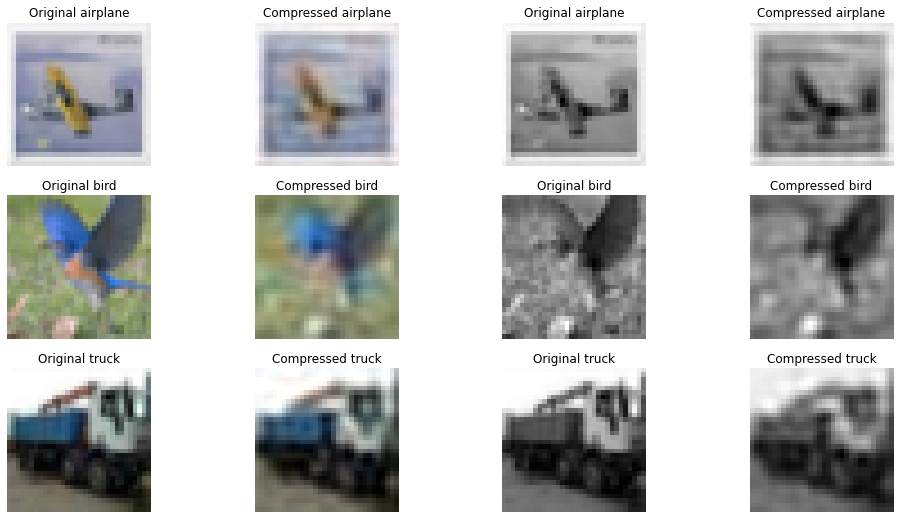

In [ ]:
columns = 4
rows = 3
fig, axs = plt.subplots(rows, columns, figsize=(17, 9))

for i in range(rows):
    rnd_idx = randrange(len(x_train))

    axs[i, 0].set_title(f"Original {classes_dim.get(np.take(y_train, rnd_idx))}")
    axs[i, 0].imshow(x_train[rnd_idx])
    axs[i, 0].set_axis_off()

    axs[i, 1].set_title(f"Compressed {classes_dim.get(np.take(y_train, rnd_idx))}")
    axs[i, 1].imshow(
        pca95.inverse_transform(x_train_pca[rnd_idx]).reshape(
            x_train[rnd_idx].shape
        )
    )
    axs[i, 1].set_axis_off()

    axs[i, 2].set_title(f"Original {classes_dim.get(np.take(y_train, rnd_idx))}")
    axs[i, 2].imshow(x_train_grey[rnd_idx], cmap="gray")
    axs[i, 2].set_axis_off()

    axs[i, 3].set_title(f"Compressed {classes_dim.get(np.take(y_train, rnd_idx))}")
    axs[i, 3].imshow(
        pca95_grey.inverse_transform(x_train_grey_pca[rnd_idx]).reshape(
            x_train_grey[rnd_idx].shape
        ),
        cmap="gray"
    )
    axs[i, 3].set_axis_off()

plt.show()    

# Dimensionality reduction with LDA

To estimate the *quality* of the **PCA** models, they will be also tested against models based on the **Linear Discriminant** technique.

This method is simpler then **PCA** because you can only obtain `n_classes - 1`

In [ ]:
# sklearn default = n_classes - 1
lda = LinearDiscriminantAnalysis(n_components=(len(classes_dim.keys()) - 1))
lda_grey = LinearDiscriminantAnalysis(n_components=(len(classes_dim.keys()) - 1))

x_train_lda = lda.fit(x_train_flat_norm, y_train.reshape(len(y_train))).transform(x_train_flat_norm)
x_train_grey_lda = lda_grey.fit(x_train_grey_flat_norm, y_train.reshape(len(y_train))).transform(x_train_grey_flat_norm)

x_test_lda = lda.transform(x_test_flat_norm)
x_test_grey_lda = lda_grey.transform(x_test_grey_flat_norm)

Below the resulted charts.

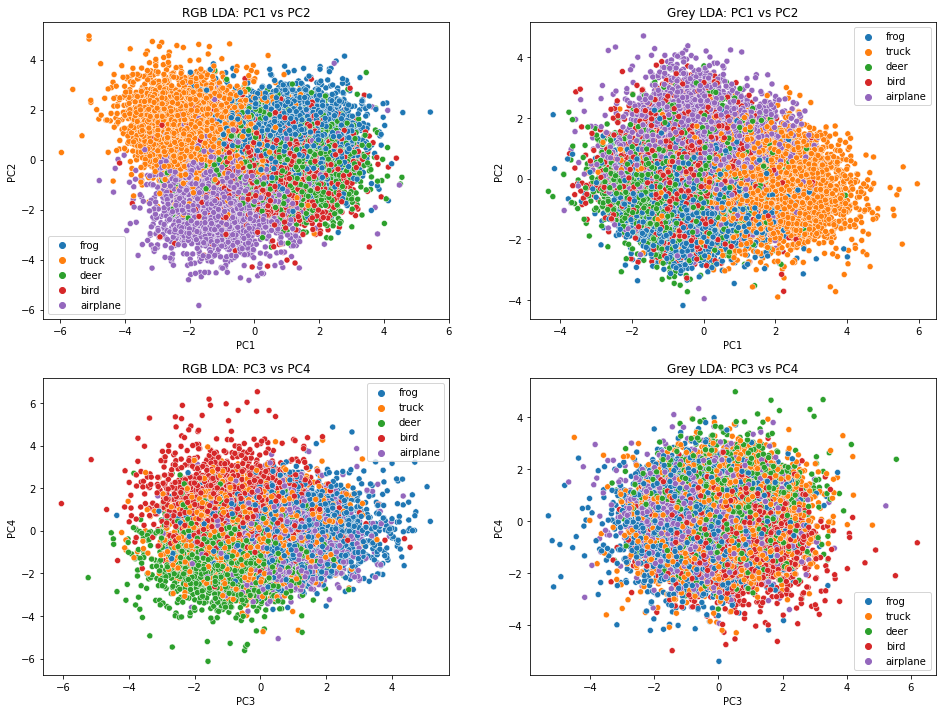

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# RGB 
sns.scatterplot(
    x=x_train_lda[:, 0], 
    y=x_train_lda[:, 1], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[0, 0],
).set_title("RGB LDA: PC1 vs PC2")
ax[0, 0].set_xlabel("PC1")
ax[0, 0].set_ylabel("PC2")

sns.scatterplot(
    x=x_train_lda[:, 2], 
    y=x_train_lda[:, 3], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[1, 0],
).set_title("RGB LDA: PC3 vs PC4")
ax[1, 0].set_xlabel("PC3")
ax[1, 0].set_ylabel("PC4")

# Grey
sns.scatterplot(
    x=x_train_grey_lda[:, 0], 
    y=x_train_grey_lda[:, 1], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[0, 1],
).set_title("Grey LDA: PC1 vs PC2")
ax[0, 1].set_xlabel("PC1")
ax[0, 1].set_ylabel("PC2")

sns.scatterplot(
    x=x_train_grey_lda[:, 2], 
    y=x_train_grey_lda[:, 3], 
    hue=pd.Series(y_train.reshape(len(y_train))).map(classes_dim),
    ax=ax[1, 1],
).set_title("Grey LDA: PC3 vs PC4")
ax[1, 1].set_xlabel("PC3")
ax[1, 1].set_ylabel("PC4")

plt.show()

## Remark: LDA vs PCA

Despite the reduced components number, **LDA** better determines the classes than **PCA**, this because the first method is *supervised* where the latter is not. Anyway, in order to make a **fair evaluation**, the results of the ML models created with the **LDA** and **PCA** models have to be taken into account.

# Linear learning method: Logistic Regression

## Disclaimer

In the code block below is reported only the most performant version for each used dataset, so the different tests on the parameters **are not** reported.

### Some used default parameters

- `cross-validation`: `K-Fold (K = 5)`
- `multiclass`: `auto`

### Hyperparameters optimization with GridSearchCV

In order to find the *best* classifier based on the original training set, the `GridSearchCV` method has been used. It creates models based on the combination of all the specified hyperparameters.

In [ ]:
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
hyperparams = dict(solver=solver_list)

lr = LogisticRegression(n_jobs=-1, C=1, random_state=34)

clf = GridSearchCV(lr, hyperparams)  # cross-validation: default 5-fold
clf.fit(x_train_flat_norm, y_train.reshape(len(y_train)))
scores = clf.cv_results_['mean_test_score']

for score, solver, in zip(scores, solver_list):
    print(f"{solver}: {score:.3f}")

## GridSearchCV results

- liblinear: 0.535
- newton-cg: 0.533
- **lbfgs: 0.560**
- sag: 0.545
- saga: 0.552

## Logistic Regression on normalized training set - *RGB*

In [ ]:
custom_clf = LogisticRegression(
    solver="lbfgs", 
    n_jobs=-1, 
    random_state=34, 
    C=1
)
custom_clf.fit(x_train_flat_norm, y_train.reshape(len(y_train)))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=34,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

### Classification results

In [ ]:
y_predict = custom_clf.predict(x_test_flat_norm)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict, 
    labels=list(classes_dim.keys()),
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.61      0.66      0.63      1000
        bird       0.44      0.40      0.42      1000
        deer       0.47      0.43      0.45      1000
        frog       0.53      0.59      0.56      1000
       truck       0.69      0.67      0.68      1000

    accuracy                           0.55      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.55      0.55      0.55      5000



### Heatmap

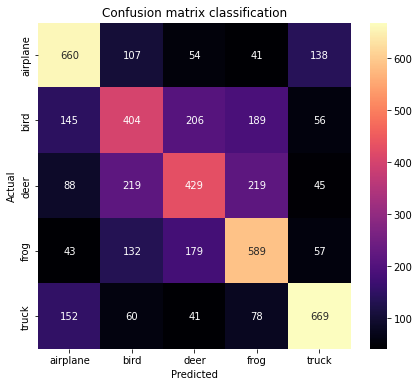

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Logistic Regression on normalized training set - *grayscale*

In [ ]:
custom_clf_grey = LogisticRegression(
    solver="lbfgs", 
    n_jobs=-1, 
    random_state=34, 
    C=1
)
custom_clf_grey.fit(x_train_grey_flat_norm, y_train.reshape(len(y_train)))

### Classification results

In [ ]:
y_predict_grey = custom_clf_grey.predict(x_test_grey_flat_norm)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_grey, 
    labels=list(classes_dim.keys()),
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.47      0.51      0.49      1000
        bird       0.33      0.28      0.30      1000
        deer       0.38      0.31      0.34      1000
        frog       0.39      0.42      0.41      1000
       truck       0.59      0.67      0.62      1000

    accuracy                           0.44      5000
   macro avg       0.43      0.44      0.43      5000
weighted avg       0.43      0.44      0.43      5000



### Heatmap

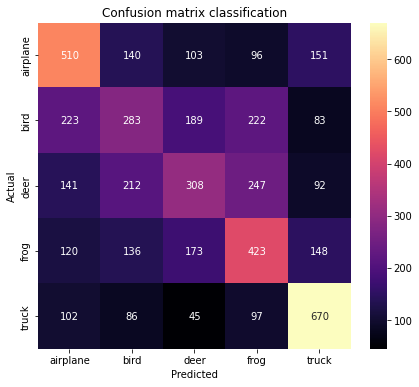

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_grey), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Note

> Due to the extremely long execution needed by the `GridSearchCV`, the next models will be created using the `RandomizedSearchCV` method.




## Common parameters for all classifiers

Below there is the list of the hyperparameters tested on the different classifiers. 

In [ ]:
hyperparams = [    
    {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': np.logspace(-4, 4, num=5),
        'solver': ['saga', 'liblinear','lbfgs', 'newton-cg'],
        'max_iter': [100, 500, 1000],
        'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
        'multi_class': ["auto", "ovr", "multinomial"],
    }
]

base_lr_clf = LogisticRegression(random_state=34, n_jobs=-1)
clf = RandomizedSearchCV(base_lr_clf, hyperparams, n_iter=20)

## Logistic Regression on PCA training set - *RGB*

In [ ]:
best_lr_clf_pca = clf.fit(x_train_pca, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters

In [ ]:
best_lr_clf_pca.best_params_

{'C': 10000.0,
 'l1_ratio': 0,
 'max_iter': 500,
 'penalty': 'none',
 'solver': 'lbfgs'}

### Classification results

In [ ]:
y_predict_pca = best_lr_clf_pca.predict(x_test_pca)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_pca, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.61      0.66      0.63      1000
        bird       0.44      0.41      0.42      1000
        deer       0.49      0.41      0.44      1000
        frog       0.55      0.64      0.59      1000
       truck       0.68      0.69      0.69      1000

    accuracy                           0.56      5000
   macro avg       0.56      0.56      0.56      5000
weighted avg       0.56      0.56      0.56      5000



### Heatmap

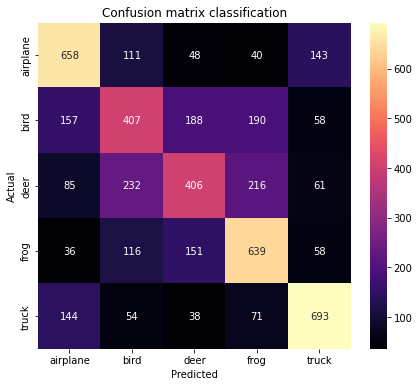

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_pca), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Logistic Regression on PCA training set - *grayscale*

In [ ]:
best_lr_clf_pca_grey = clf.fit(x_train_grey_pca, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters


In [ ]:
best_lr_clf_pca_grey.best_params_

{'C': 0.0001,
 'l1_ratio': 1,
 'max_iter': 1000,
 'penalty': 'l2',
 'solver': 'newton-cg'}

### Classification results

In [ ]:
y_predict_pca_grey = best_lr_clf_pca_grey.predict(x_test_grey_pca)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_pca_grey, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.47      0.50      0.49      1000
        bird       0.35      0.27      0.31      1000
        deer       0.42      0.35      0.38      1000
        frog       0.43      0.50      0.46      1000
       truck       0.60      0.67      0.64      1000

    accuracy                           0.46      5000
   macro avg       0.45      0.46      0.45      5000
weighted avg       0.45      0.46      0.45      5000



### Heatmap

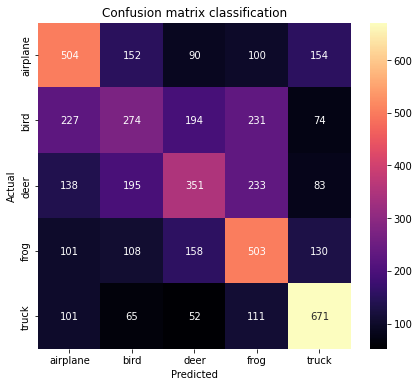

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_pca_grey), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Logistic Regression on LDA training set - *RGB*

In [ ]:
best_lr_clf_lda = clf.fit(x_train_lda, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters


In [ ]:
best_lr_clf_lda.best_params_

{'C': 1.0,
 'l1_ratio': 1,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs'}

### Classification results

In [ ]:
y_predict_lda = best_lr_clf_lda.predict(x_test_lda)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_lda, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.60      0.63      0.62      1000
        bird       0.39      0.40      0.40      1000
        deer       0.41      0.36      0.38      1000
        frog       0.50      0.52      0.51      1000
       truck       0.65      0.65      0.65      1000

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000



### Heatmap

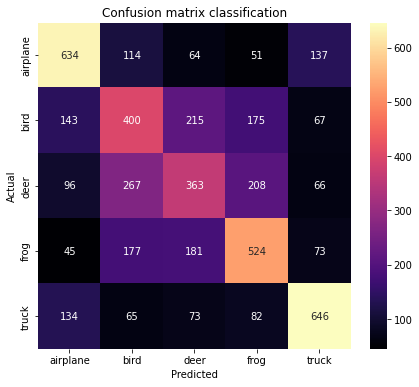

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_lda), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Logistic Regression on LDA training set - *grayscale*

In [ ]:
best_lr_clf_lda_grey = clf.fit(x_train_grey_lda, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters


In [ ]:
best_lr_clf_lda_grey.best_params_

{'C': 0.01,
 'l1_ratio': 1,
 'max_iter': 500,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'saga'}

### Classification results

In [ ]:
y_predict_lda_grey = best_lr_clf_lda_grey.predict(x_test_grey_lda)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_lda_grey, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.48      0.50      0.49      1000
        bird       0.30      0.28      0.29      1000
        deer       0.33      0.30      0.31      1000
        frog       0.37      0.38      0.37      1000
       truck       0.60      0.65      0.62      1000

    accuracy                           0.42      5000
   macro avg       0.41      0.42      0.42      5000
weighted avg       0.41      0.42      0.42      5000



### Heatmap

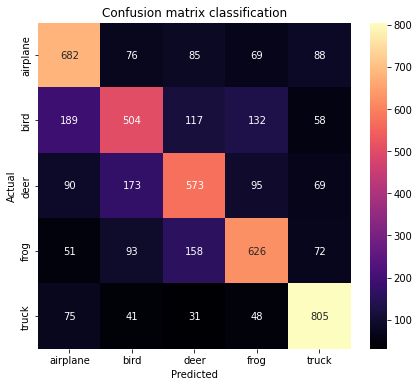

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_lda_grey), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Results evaluation

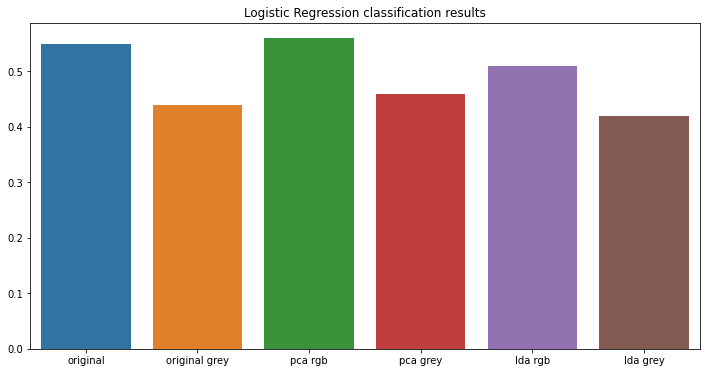

In [ ]:
cl_results = {
    'original': 0.55,
    'original grey': 0.44,
    'pca rgb': 0.56,
    'pca grey': 0.46,
    'lda rgb': 0.51,
    'lda grey': 0.42,
}

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x=list(cl_results.keys()),
    y=list(cl_results.values()),
).set_title('Logistic Regression classification results')
plt.show()

### Observation

The **PCA-RGB** model is slightly better than the **orginal** dataset.

The **PCA-RGB** is the best choice for `accuracy`.

# Ensemble method: Random Forest

After the **Logistic Regression** classifiers, an *ensemble method* model seemed a valid alternative to test (**Random Forest** in this case). 

## Common parameters for all classifiers

The values were chosen based on empirical results and then comparing them with other online models.

### Some used default parameters

- `cross-validation`: `K-Fold (K = 5)`

In [ ]:
hyperparameters = {
    'n_estimators': [100, 200, 600],
    'max_depth': [200, 400, 600, 800, None],
    'min_samples_split': [5, 25, 50],
    'min_samples_leaf': [5, 10, 20],
}

base_rf_clf = RandomForestClassifier(random_state=34)
clf = RandomizedSearchCV(
    base_rf_clf, 
    hyperparameters, 
    random_state=34, 
    n_jobs=-1, 
    n_iter=20
)

## Random Forest on normalized training set

In [ ]:
best_rf_clf = clf.fit(x_train_flat_norm, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters

In [ ]:
best_rf_clf.best_params_

{'max_depth': 400,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 200}

### Classification results

In [ ]:
y_predict = best_rf_clf.predict(x_test_flat_norm)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.70      0.72      0.71      1000
        bird       0.53      0.44      0.48      1000
        deer       0.54      0.47      0.50      1000
        frog       0.59      0.69      0.63      1000
       truck       0.71      0.78      0.74      1000

    accuracy                           0.62      5000
   macro avg       0.61      0.62      0.61      5000
weighted avg       0.61      0.62      0.61      5000



### Heatmap

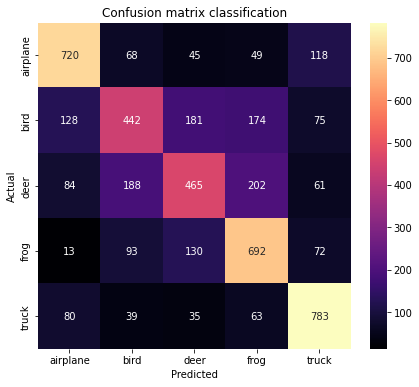

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Random Forest on PCA training set - *RGB*

In [ ]:
best_rf_clf_pca = clf.fit(x_train_pca, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters

In [ ]:
best_rf_clf_pca.best_params_

{'max_depth': 400,
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'n_estimators': 600}

### Classification results

In [ ]:
y_predict_pca = best_rf_clf_pca.predict(x_test_pca)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_pca, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.68      0.71      0.69      1000
        bird       0.55      0.38      0.45      1000
        deer       0.60      0.47      0.53      1000
        frog       0.59      0.71      0.65      1000
       truck       0.65      0.84      0.73      1000

    accuracy                           0.62      5000
   macro avg       0.61      0.62      0.61      5000
weighted avg       0.61      0.62      0.61      5000



### Heatmap

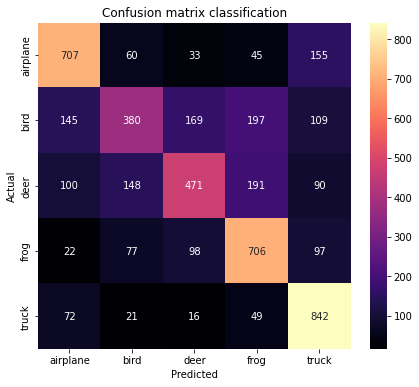

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_pca), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Random Forest on PCA training set - *grayscale*

In [ ]:
best_rf_clf_pca_grey = clf.fit(x_train_grey_pca, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters

In [ ]:
best_rf_clf_pca_grey.best_params_

{'max_depth': 400,
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'n_estimators': 600}

### Classification results

In [ ]:
y_predict_pca_grey = best_rf_clf_pca_grey.predict(x_test_grey_pca)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_pca_grey, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.59      0.57      0.58      1000
        bird       0.49      0.30      0.37      1000
        deer       0.51      0.42      0.46      1000
        frog       0.51      0.64      0.57      1000
       truck       0.61      0.81      0.70      1000

    accuracy                           0.55      5000
   macro avg       0.54      0.55      0.53      5000
weighted avg       0.54      0.55      0.53      5000



### Heatmap

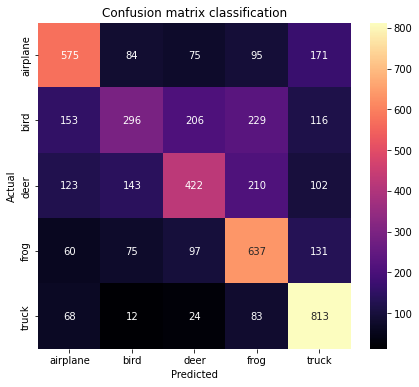

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_pca_grey), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Random Forest on LDA training set - *RGB*

In [ ]:
best_rf_clf_lda = clf.fit(x_train_lda, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters

In [ ]:
best_rf_clf_lda.best_params_

{'max_depth': 600,
 'min_samples_leaf': 10,
 'min_samples_split': 50,
 'n_estimators': 100}

### Classification results

In [ ]:
y_predict_lda = best_rf_clf_lda.predict(x_test_lda)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_pca_grey, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.59      0.57      0.58      1000
        bird       0.49      0.30      0.37      1000
        deer       0.51      0.42      0.46      1000
        frog       0.51      0.64      0.57      1000
       truck       0.61      0.81      0.70      1000

    accuracy                           0.55      5000
   macro avg       0.54      0.55      0.53      5000
weighted avg       0.54      0.55      0.53      5000



### Heatmap

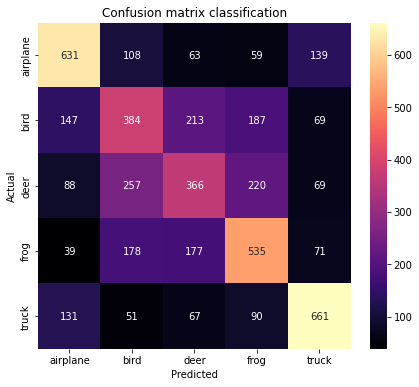

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_lda), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Random Forest on LDA training set - *grayscale*

In [ ]:
best_rf_clf_lda_grey = clf.fit(x_train_grey_lda, y_train.reshape(len(y_train)))

### Best classifier's hyperparameters

In [ ]:
best_rf_clf_lda_grey.best_params_

{'max_depth': 200,
 'min_samples_leaf': 20,
 'min_samples_split': 50,
 'n_estimators': 200}

### Classification results

In [ ]:
y_predict_lda_grey = best_rf_clf_lda_grey.predict(x_test_grey_lda)

print(classification_report(
    y_test.reshape(len(y_test)), 
    y_predict_lda_grey, 
    target_names=list(classes_dim.values())
))

              precision    recall  f1-score   support

    airplane       0.50      0.48      0.49      1000
        bird       0.32      0.32      0.32      1000
        deer       0.34      0.32      0.33      1000
        frog       0.38      0.38      0.38      1000
       truck       0.59      0.64      0.61      1000

    accuracy                           0.43      5000
   macro avg       0.43      0.43      0.43      5000
weighted avg       0.43      0.43      0.43      5000



### Heatmap

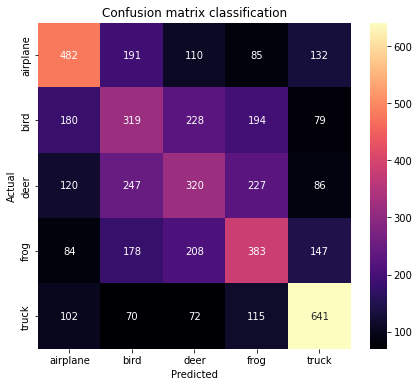

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(
    confusion_matrix(y_test.reshape(len(y_test)), y_predict_lda_grey), 
    annot=True, 
    fmt='d',
    xticklabels=list(classes_dim.values()), 
    yticklabels=list(classes_dim.values()),
    cmap="magma"
).set_title("Confusion matrix classification")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

## Results evaluation

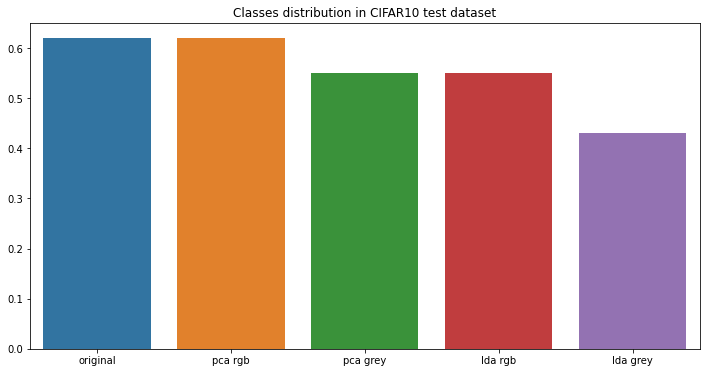

In [ ]:
cl_results = {
    'original': 0.62,
    'pca rgb': 0.62,
    'pca grey': 0.55,
    'lda rgb': 0.55,
    'lda grey': 0.43,
}

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x=list(cl_results.keys()),
    y=list(cl_results.values()),
).set_title('Random Forest classification results')
plt.show()

### Observation

There is a 10% improvement than the Logistic Regression model.

In thi case, the **PCA-RGB** model seems the best choice for `accuracy`.

# Deep Learning algorithm: Convolutional Neural Network

The **convolutional neural network** is one of the most powerful and accurate algorithms. This method is mandatory for a complete comparison among machine learning methods.

## Dataset preprocessing

A neural netwok is *complex* enough to support **RGB** images.

The only **preprocessing** operation will be the normalization the pixel values between 0 and 1.

In [ ]:
COSTANT = 255

x_train_norm = x_train.astype("float32") / COSTANT
x_test_norm = x_test.astype("float32") / COSTANT

input_shape = x_train_norm[0].shape  # retrieve the dimensions of a train element.

## Validation dataset creation for **early stopping** criteria

In [ ]:
x_train_norm, x_val_norm, y_train, y_val = train_test_split(
    x_train_norm, 
    y_train,
    test_size=0.1, 
    shuffle=False
)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(
    y_train.reshape(len(y_train)), 
    len(classes_dim.keys())
)
y_val = keras.utils.to_categorical(
    y_val.reshape(len(y_val)), 
    len(classes_dim.keys())
)
y_test = keras.utils.to_categorical(
    y_test.reshape(len(y_test)), 
    len(classes_dim.keys())
)

## Model construction

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(classes_dim.keys()), activation="softmax"),
    ]
)

### Model structure

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2304)             

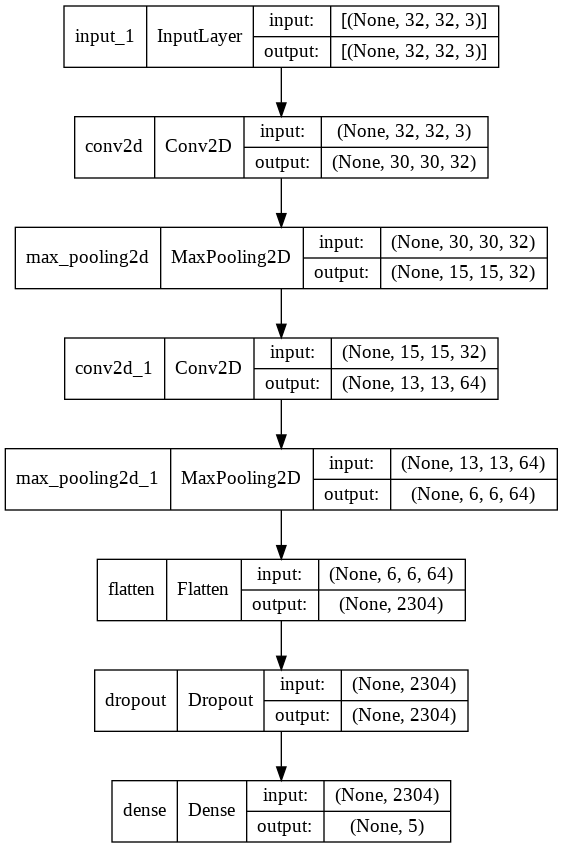

In [ ]:
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=False, dpi=96
)

### Training the model

Common training parameters.

In [ ]:
batch_size = 32
epochs = 20

`EarlyStopping` criteria definition.

In [ ]:
stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

Custom model training:

In [ ]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)
history = model.fit(
    x_train_norm, 
    y_train, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_data=(x_val_norm, y_val),
    callbacks=[stop_early]
)

Epoch 1/20
704/704 [==============================] - 6s 7ms/step - loss: 1.0988 - accuracy: 0.5500 - val_loss: 0.9105 - val_accuracy: 0.6552
Epoch 2/20
704/704 [==============================] - 5s 7ms/step - loss: 0.9053 - accuracy: 0.6475 - val_loss: 0.8247 - val_accuracy: 0.6812
Epoch 3/20
704/704 [==============================] - 5s 7ms/step - loss: 0.8133 - accuracy: 0.6873 - val_loss: 0.7059 - val_accuracy: 0.7372
Epoch 4/20
704/704 [==============================] - 5s 7ms/step - loss: 0.7511 - accuracy: 0.7119 - val_loss: 0.6540 - val_accuracy: 0.7612
Epoch 5/20
704/704 [==============================] - 5s 7ms/step - loss: 0.7069 - accuracy: 0.7348 - val_loss: 0.6289 - val_accuracy: 0.7660
Epoch 6/20
704/704 [==============================] - 5s 7ms/step - loss: 0.6807 - accuracy: 0.7452 - val_loss: 0.5990 - val_accuracy: 0.7780
Epoch 7/20
704/704 [==============================] - 5s 7ms/step - loss: 0.6481 - accuracy: 0.7607 - val_loss: 0.5946 - val_accuracy: 0.7800
Epoch 

### Results evaluation

In [ ]:
score = model.evaluate(x_test_norm, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5248627066612244
Test accuracy: 0.8108000159263611


## Hyperparameters improvement

Made with `keras-tuner`.

### Building method

This function specifies the possible values of the hyperparameters that will be tested by the **search algorithms** that will be called later.

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.Input(shape=input_shape))
    model.add(layers.Conv2D(
        filters=hp.Int("conv_1_filter", min_value=32, max_value=128, step=32), 
        kernel_size=hp.Choice("conv_1_kernel", values=[3, 5, 7]), 
        # padding="same",
        activation="relu"
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(
        filters=hp.Int("conv_2_filter", min_value=32, max_value=128, step=32), 
        kernel_size=hp.Choice("conv_2_kernel", values=[3, 5, 7]), 
        # padding="same",
        activation="relu"
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(
        rate=hp.Float("dropout_rate", min_value=0.2, max_value=0.8, step=0.2)
    ))
    model.add(layers.Dense(len(classes_dim.keys()), activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Best model searching with `RandomSearch`

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",  # accuracy sul dataset di validazione
    max_trials=10,
    overwrite=True,
    directory="csl_project",
    project_name="cnn_random_search",
)
tuner.search(
    x_train_norm, 
    y_train, 
    epochs=epochs,
    callbacks=[stop_early],
    validation_data=(x_val_norm, y_val)
)

best_model = tuner.get_best_models()[0]

### Migliori iperparametri trovati



In [ ]:
print(f"First Conv2D filter: {tuner.get_best_hyperparameters()[0].get('conv_1_filter')}")
print(f"First Conv2D kernel: {tuner.get_best_hyperparameters()[0].get('conv_1_kernel')}")
print(f"Second Conv2D filter: {tuner.get_best_hyperparameters()[0].get('conv_2_filter')}")
print(f"Second Conv2D kernel: {tuner.get_best_hyperparameters()[0].get('conv_2_kernel')}")
print(f"Dropout rate: {tuner.get_best_hyperparameters()[0].get('dropout_rate')}")
print(f"Learning rate: {tuner.get_best_hyperparameters()[0].get('learning_rate')}")

First Conv2D filter: 128
First Conv2D kernel: 5
Second Conv2D filter: 64
Second Conv2D kernel: 7
Dropout rate: 0.4
Learning rate: 0.001


### Sruttura del modello

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        401472    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dropout (Dropout)           (None, 4096)              0

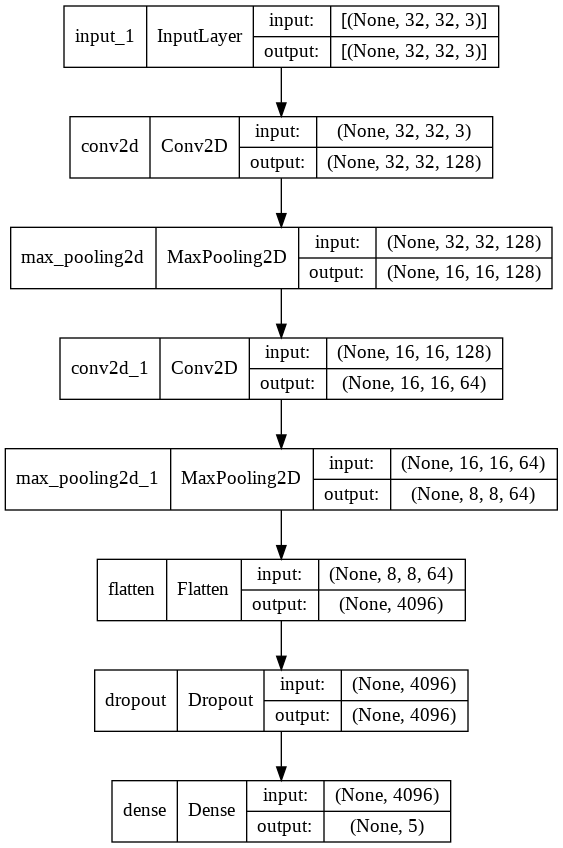

In [ ]:
keras.utils.plot_model(
    best_model, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=False, dpi=96
)

### Valutazione dei risultati

In [ ]:
score = best_model.evaluate(x_test_norm, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5444953441619873
Test accuracy: 0.8101999759674072


## Modello alternativo con Hyperband

Di seguito è riportata la descrizione dell'algoritmo Hyperband presa direttamente da [TensorFlow](https://www.tensorflow.org/tutorials/keras/keras_tuner):

> The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer.



In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    overwrite=True,
    directory='csl_project',
    project_name='cnn_hyperband'
)
tuner.search(
    x_train_norm, 
    y_train, 
    epochs=epochs,
    callbacks=[stop_early],
    validation_data=(x_val_norm, y_val)
)

best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 02m 23s]
val_accuracy: 0.823199987411499

Best val_accuracy So Far: 0.8424000144004822
Total elapsed time: 00h 23m 34s
INFO:tensorflow:Oracle triggered exit


### Best hyperparameters found


In [ ]:
print(f"First Conv2D filter: {best_hps.get('conv_1_filter')}")
print(f"First Conv2D kernel: {best_hps.get('conv_1_kernel')}")
print(f"Second Conv2D filter: {best_hps.get('conv_2_filter')}")
print(f"Second Conv2D kernel: {best_hps.get('conv_2_kernel')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

First Conv2D filter: 64
First Conv2D kernel: 3
Second Conv2D filter: 96
Second Conv2D kernel: 7
Dropout rate: 0.2
Learning rate: 0.001


### *Found* model training

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hyperband_model = tuner.hypermodel.build(best_hps)
history = hyperband_model.fit(
    x_train_norm, 
    y_train, 
    epochs=50, 
    validation_data=(x_val_norm, y_val),
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
704/704 [==============================] - 9s 12ms/step - loss: 1.0341 - accuracy: 0.5852 - val_loss: 1.0571 - val_accuracy: 0.5624
Epoch 2/50
704/704 [==============================] - 8s 11ms/step - loss: 0.7719 - accuracy: 0.7068 - val_loss: 0.6806 - val_accuracy: 0.7396
Epoch 3/50
704/704 [==============================] - 7s 10ms/step - loss: 0.6617 - accuracy: 0.7521 - val_loss: 0.6243 - val_accuracy: 0.7520
Epoch 4/50
704/704 [==============================] - 7s 10ms/step - loss: 0.5802 - accuracy: 0.7845 - val_loss: 0.5656 - val_accuracy: 0.7884
Epoch 5/50
704/704 [==============================] - 7s 10ms/step - loss: 0.5292 - accuracy: 0.8033 - val_loss: 0.5871 - val_accuracy: 0.7880
Epoch 6/50
704/704 [==============================] - 7s 11ms/step - loss: 0.4914 - accuracy: 0.8165 - val_loss: 0.5055 - val_accuracy: 0.8052
Epoch 7/50
704/704 [==============================] - 7s 11ms/step - loss: 0.4456 - accuracy: 0.8360 - val_loss: 0.5708 - val_accuracy: 0.7936



Once we find the best epoch, we re-train the model with that number of epochs.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)


# Retrain the model
history = hypermodel.fit(
    x_train_norm, 
    y_train, 
    epochs=best_epoch, 
    validation_data=(x_val_norm, y_val),
)

Epoch 1/32
704/704 [==============================] - 9s 11ms/step - loss: 1.0127 - accuracy: 0.5876 - val_loss: 0.8013 - val_accuracy: 0.6908
Epoch 2/32
704/704 [==============================] - 8s 11ms/step - loss: 0.7541 - accuracy: 0.7136 - val_loss: 0.7477 - val_accuracy: 0.7140
Epoch 3/32
704/704 [==============================] - 7s 10ms/step - loss: 0.6235 - accuracy: 0.7657 - val_loss: 0.6228 - val_accuracy: 0.7656
Epoch 4/32
704/704 [==============================] - 7s 11ms/step - loss: 0.5630 - accuracy: 0.7899 - val_loss: 0.5476 - val_accuracy: 0.7952
Epoch 5/32
704/704 [==============================] - 7s 10ms/step - loss: 0.5084 - accuracy: 0.8116 - val_loss: 0.5631 - val_accuracy: 0.7980
Epoch 6/32
704/704 [==============================] - 7s 10ms/step - loss: 0.4722 - accuracy: 0.8249 - val_loss: 0.5433 - val_accuracy: 0.7948
Epoch 7/32
704/704 [==============================] - 7s 10ms/step - loss: 0.4303 - accuracy: 0.8449 - val_loss: 0.5139 - val_accuracy: 0.8184

### Results evaluation

In [ ]:
score = hypermodel.evaluate(x_test_norm, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7809262275695801
Test accuracy: 0.8133999705314636


## Observation

The search for the best hyperparameters did not bring amazing results, probably because the network created was so simple that it was fairly constant in performance.

# Whole evaluation and conclusions

Below are listed the results of the best models for each method.

The improvement in prediction brought by the **convolutional neural network** is clear, so the choice to include it was correct.

The creation of a grayscale dataset **did not** bring the desired results, probably because the images are quite complex and the models were not be able to extract the **dominant features** from them, thus struggling to classify them well.

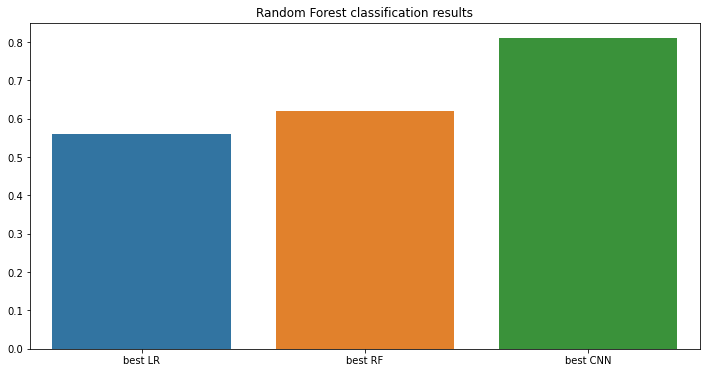

In [ ]:
cl_results = {
    'best LR': 0.56,
    'best RF': 0.62,
    'best CNN': 0.81,
}

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x=list(cl_results.keys()),
    y=list(cl_results.values()),
).set_title('Random Forest classification results')
plt.show()